In [55]:
import os

from dotenv import load_dotenv

load_dotenv()

True

In [65]:
!pip install langgraph

  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.2.37
    Uninstalling langchain-core-0.2.37:
      Successfully uninstalled langchain-core-0.2.37


In [36]:
from langchain_teddynote import logging
logging.langsmith("CH17-LANGGRAPH")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LANGGRAPH


In [60]:
from typing import TypedDict

class GraphState(TypedDict):
    goal: str
    todo: list[str]
    current_job: str
    total_time: int
    time_spent: int
    status: str
    

In [58]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import CommaSeparatedListOutputParser


def create_todo_list(goal):
    output_parser = CommaSeparatedListOutputParser()
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "당신은 나의 할일을 관리하는 비서입니다. 당신의 임무는 나를 위하여 주어진 목표에 대하여 할일 목록을 작성하는 것입니다.",
            ),
            (
                "human",
                "주어진 목표(goal)를 잘 수행하기 위하여 할일 목록을 작성해 주세요. `할일:걸리는시간(hour)` 으로 작성하세요. 걸리는 시간은 반올림하여 int 로 작성하세요.\n\n#목표: {goal}\n\n#형식: {format_instuctions}",
            ),
        ]
    )
    prompt = prompt.partial(format_instuctions=output_parser.get_format_instructions())
    llm = ChatOpenAI(model_name="gpt-4-turbo")
    chain = prompt | llm | CommaSeparatedListOutputParser()

    output = chain.invoke({"goal": goal})
    return output

In [59]:
todo = create_todo_list("LangChain 튜토리얼로 RAG 공부하기")
todo

['LangChain 공식 웹사이트 방문:1',
 'RAG 모델 개념 이해하기:2',
 'LangChain 튜토리얼 검색 및 선택:1',
 '선택한 튜토리얼 따라하기:3',
 'RAG 모델을 사용한 예제 문제 풀기:2',
 '학습 내용 정리 및 복습:2']

## 

In [67]:
def list_todo(state: GraphState) -> GraphState:
    goal = state["goal"]
    # 리스트 작성
    todo = create_todo_list(goal)
    # 할 일 목록을 포맷팅
    todo = format_task(create_todo_list(todo))
    return GraphState(todo=todo)


def start_job(state: GraphState) -> GraphState:
    todo = state["todo"]
    if len(todo):
        current_job, total_time = todo.pop(0)
        status = "진행중"
        time_spent = 0
    return GraphState(
        current_job=current_job,
        total_time=total_time,
        status=status,
        time_spent=time_spent,
    )


def process_job(state: GraphState) -> GraphState:
    time_spent = state["time_spent"]
    time_spent += 1

    return GraphState(time_spent=time_spent)


def check_progress(state: GraphState) -> GraphState:
    if state["time_spent"] >= state["total_time"]:
        status = "다음 작업"
        if len(state["todo"]) == 0:
            status = "종료"
    else:
        status = "진행중"
    return GraphState(status=status)


def next_step(state: GraphState) -> GraphState:
    return state["status"]

In [68]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# Todo 를 작성합니다.
workflow.add_node("list_todo", list_todo)  # 에이전트 노드를 추가합니다.

# Todo 작업을 시작합니다.
workflow.add_node("start_job", start_job)

# 작업을 진행합니다.
workflow.add_node("process_job", process_job)

# 작업을 중간 체크합니다.
workflow.add_node("check_progress", check_progress)

# 각 노드들을 연결합니다.
workflow.add_edge("list_todo", "start_job")
workflow.add_edge("start_job", "process_job")
workflow.add_edge("process_job", "check_progress")

# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "check_progress",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    next_step,
    {
        "진행중": "process_job",  # 관련성이 있으면 종료합니다.
        "다음 작업": "start_job",  # 관련성이 없으면 다시 답변을 생성합니다.
        "종료": END,  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
    },
)

# 시작점을 설정합니다.
workflow.set_entry_point("list_todo")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
app = workflow.compile(checkpointer=memory)

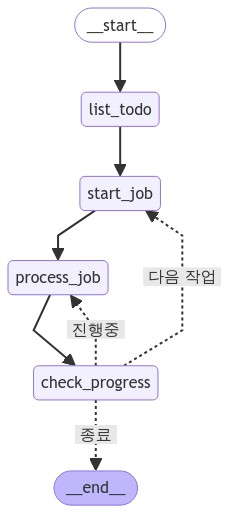

In [69]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
       # xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [70]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "TODO"})

# GraphState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(goal="랭체인(LangChain) 밋업에서 발표자료를 준비하기")

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"[NODE] {key}")
            for k, v in value.items():
                pprint.pprint(f"<{k}> {v}")
            pprint.pprint("===" * 10)
            # 출력 값을 예쁘게 출력합니다.
            # pprint.pprint(value, indent=2, width=80, depth=None)
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

NameError: name 'format_task' is not defined